# 3350 Final Project : Ted Talks
## By: Eliza Salamon (ecs287)

# 1. Introduction and Hypothesis

TED Talks are a ubiquitous cultural phenomenon — almost every year of my education has featured at least one TED Talk in class. Both traditional celebrities, business people, and experts in their fields are featured in these videos, giving speeches under twenty minutes which describe and analyze a wide range of topics: the TED Talk tagline is "ideas worth spreading." TED Talks are useful for providing an engaging and succinct introduction to audiences, but have also been critiqued for their surface level talking points:

> ##### "But plenty of observers have argued that some of the new channels for distributing information simplify and flatten the world of ideas, that they valorize in particular a quick-hit, name-branded, business-friendly kind of self-helpish insight—or they force truly important ideas into that kind of template. They favor the kind of idea that fits into our “life hacking” culture: providing pointers or data that can be translated into improved productivity or happiness (often assumed to be the same)"  --- Christopher Shea in "The New Academic Celebrity"

On its website, TED Talks has a [page](https://www.ted.com/playlists/56/making_sense_of_too_much_data) titled "Making Sense of Too Much Data," featuring talks highlighting big data. There's a lot of data out there — and the descriptions and transcripts of TED Talks themselves are included! From a Natural Language Processing perspective, TED Talks provide a wealth of data through their transcripts. Multiple studies have analyzed TED Talk speeches in different ways. Some projects analyze how views are affected by factors such as valence and sentiment — [Affect in science communication: A data-driven analysis of TED talks on YouTube](https://osf.io/preprints/psyarxiv/28yc5), the demographics of the their speakers — [Scientists Popularizing Science: Characteristics and Impact of TED Talk Presenters](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0062403), and the topics discussed in speeches — [Mining Popular Trends from TED Talk Data](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10143092).

I am particularly intersted in connecting the critiques of TED Talks which assert that it "dumbs down" academia and research into a text mining project. In one research project, Peter Wingrove, using the same baseline as my anecdotal observation of TED Talk prevalence as a part of modern education, found that TED Talks have significantly less academic vernacular than university lectures — [How suitable are TED talks for academic listening?](https://www.sciencedirect.com/science/article/pii/S1475158517301029#sec5)

I was further inspired by the [RELIC](https://arxiv.org/pdf/2203.10053.pdf) paper, which looked to rank semantically related text.


My dataset, scraped and organized by Katherine M. Kinnaird and John Laudun for a 2018 paper entitled ["TED Talks as Data"](https://culturalanalytics.org/article/11044-ted-talks-as-data), contains 992 TED Talks given between 2006 and 2018, with their full transcripts and speaker biographies. I am interested in the relationship between author biography and the speech they give. Presumably, speakers invited to TED Talks give speeches about topics they are interested in, which will align with their background, career, accomplishments, etc, which are generally outlined in a person's biography. Due to the criticism of TED talks as being surface level and predictable, I want to explore whether models are successful at matching speech transcripts to the biographies of their speakers — and hypothesize that they will not.


**Hypothesis 1**: Models measuring similarity and performing similarity retrieval tasks will not be very successful at matching TED Talk transcript to speaker biography. Due to the broad nature and concepts inherent to TED talks, speech trancripts will not show strong similarities to speaker biographies in vocabulary and contextual methods that models provide.

**Hypothesis 2**: I propose that TED Talk transcripts are relate to their speaker biographies in varied ways that extend beyond observable semantics.

# 2. Data and Methods


## 2.1 Similarities between Speeches and Speaker Biographies

In [ ]:
!pip install pyLDAvis
!pip install faiss-gpu
!pip install datasets

In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, TruncatedSVD
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
import torch
from transformers import AutoTokenizer, AutoModel
import pyLDAvis.lda_model
from nltk.corpus import stopwords
import re
import nltk
import faiss
from datasets import Dataset
import textwrap

/usr/local/lib/python3.10/dist-packages/faiss/loader.py:28: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numpy.__version__) >= "1.19":
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive


In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
#import dataset
df = pd.read_csv('/content/drive/MyDrive/3350/TEDonly_speakers_final.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,...,speaker2_introduction,speaker2_profile,speaker_3,speaker3_occupation,speaker3_introduction,speaker3_profile,speaker_4,speaker4_occupation,speaker4_introduction,speaker4_profile
0,1,https://www.ted.com/talks/al_gore_on_averting_...,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,0:16:17,6/27/06,"alternative energy,cars,global issues,climate ...",3266733,"Thank you so much, Chris. And it's truly a g...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,https://www.ted.com/talks/david_pogue_says_sim...,Simplicity sells,New York Times columnist David Pogue takes aim...,TED2006,0:21:26,6/27/06,"simplicity,entertainment,interface design,soft...",1702201,"(Music: ""The Sound of Silence,"" Simon & Garf...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53,https://www.ted.com/talks/majora_carter_s_tale...,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",TED2006,0:18:36,6/27/06,"MacArthur grant,cities,green,activism,politics...",2000421,If you're here today — and I'm very happy th...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,66,https://www.ted.com/talks/ken_robinson_says_sc...,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,TED2006,0:19:24,6/27/06,"children,teaching,creativity,parenting,culture...",51614087,Good morning. How are you? (Laughter) ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,92,https://www.ted.com/talks/hans_rosling_shows_t...,The best stats you've ever seen,You've never seen data presented like this. Wi...,TED2006,0:19:50,6/27/06,"demo,Asia,global issues,visualizations,global ...",12662135,"About 10 years ago, I took on the task to te...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print('There are {} TED Talks represented'.format(len(df)))

There are 992 TED Talks represented


In [7]:
print('{} of these talks only have one speaker'.format(df.speaker_2.isna().sum()))
print('Because most only have one speaker, I will drop all columns representing multiple speakers')

966 of these talks only have one speaker
Because most only have one speaker, I will drop all columns representing multiple speakers


In [8]:
df.drop(columns=['speaker_2', 'speaker2_occupation', 'speaker2_introduction',
                 'speaker2_profile', 'speaker_3', 'speaker3_occupation', 'speaker3_introduction',
                 'speaker3_profile', 'speaker_4', 'speaker4_occupation', 'speaker4_introduction', 'speaker4_profile'], inplace=True)
df.head()

,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,speaker_1,speaker1_occupation,speaker1_introduction,speaker1_profile
0,1,https://www.ted.com/talks/al_gore_on_averting_...,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,0:16:17,6/27/06,"alternative energy,cars,global issues,climate ...",3266733,"Thank you so much, Chris. And it's truly a g...",Al Gore,Climate advocate,Nobel Laureate Al Gore focused the world’s att...,Why you should listen\nFormer Vice President A...
1,7,https://www.ted.com/talks/david_pogue_says_sim...,Simplicity sells,New York Times columnist David Pogue takes aim...,TED2006,0:21:26,6/27/06,"simplicity,entertainment,interface design,soft...",1702201,"(Music: ""The Sound of Silence,"" Simon & Garf...",David Pogue,Technology columnist,David Pogue is the personal technology columni...,Why you should listen\nWhich cell phone to cho...
2,53,https://www.ted.com/talks/majora_carter_s_tale...,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",TED2006,0:18:36,6/27/06,"MacArthur grant,cities,green,activism,politics...",2000421,If you're here today — and I'm very happy th...,Majora Carter,Activist for environmental justice,Majora Carter redefined the field of environme...,Why you should listen\nMajora Carter is a visi...
3,66,https://www.ted.com/talks/ken_robinson_says_sc...,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,TED2006,0:19:24,6/27/06,"children,teaching,creativity,parenting,culture...",51614087,Good morning. How are you? (Laughter) ...,Ken Robinson,Author/educator,Creativity expert Sir Ken Robinson challenges ...,Why you should listen\nWhy don't we get the be...
4,92,https://www.ted.com/talks/hans_rosling_shows_t...,The best stats you've ever seen,You've never seen data presented like this. Wi...,TED2006,0:19:50,6/27/06,"demo,Asia,global issues,visualizations,global ...",12662135,"About 10 years ago, I took on the task to te...",Hans Rosling,Global health expert; data visionary,"In Hans Rosling’s hands, data sings. Global tr...",Why you should listen\nEven the most worldly a...


## Data Description

The most important columns for text analysis purposes are the headline, description, text, speaker1_introduction, and speaker1_profile.

- Headline: Title of the TED Talk
- Description: Longer description of the TED Talk
- Text: Transcript of TED Talk, including audience reactions such as (Laughter)
- Speaker Introduction: Short blurb about the speaker
- Speaker Profile: Longer biography of the speaker

### Cleaning Data

In [9]:
def remove_from_transcript(text):
    #remove unwanted characters from transcript
    text = text.replace('\\', '').replace('(Laughter)', '').replace('(Applause)', '').replace('♫', '')
    text = re.sub("\(.*?\)","",text)
    text = re.sub(' +', ' ', text)
    return text

In [10]:
df['text'] = [remove_from_transcript(t) for t in df['text']]

In [11]:
#remove unwanted prefix and suffixes from biographies
df['speaker1_profile'] = [bio.split('Why you should listen\n')[1] for bio in df['speaker1_profile']]
df['speaker1_profile'] = [bio.split('\nWhat others say')[0] for bio in df['speaker1_profile']]

In [12]:
df.fillna("",inplace=True)

## Calculating Similarities

Multiple ways of tokenizing and embedding texts to calculate the cosine similarities will be tested

1. TF-IDF vectorizer
2. LDA topic modeling
3. BERT embeddings

Broad outline for each model: I will create a function to select two TED talk speaker descriptions at random, and the transcript for one of those talks. I will then calculate the similarity between the speech transcript and the two speaker biographies and return the biography with the highest similarity score.

In [13]:
def get_speeches(data):
    """
    Randomly select a speech from the dataset, as well as four others to run the

    Returns the target speech title, transcript, and speaker biography
    """
    samples = data.sample(n=1)
    true_talk = samples.iloc[0]
    true_title = true_talk['headline']
    true_text = true_talk['text']
    true_bio = true_talk['speaker1_profile']

    return true_title, true_text, true_bio

In [14]:
def calculate_similarity(transcript, bios, vectorizer):
    """
    Given all potential bios, the target bio, speech transcript and a vectorizer,
    calculate the cosine similarity between the vectorized transcript and each bio.

    Returns the top 5 highest similarities
    """
    transcript = vectorizer.transform([transcript])
    bios = vectorizer.transform(bios)
    sims = cosine_similarity(transcript, bios)

    return sims

In [15]:
def calculate_similarity_lda(transcript, bios, vectorizer, lda):
    """
    Given all potential bios, the target bio, speech transcript and a vectorizer,
    calculate the cosine similarity between the vectorized transcript and each bio.

    Returns the top 5 highest similarities
    """
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        transcript = lda.transform(vectorizer.transform([transcript]))
        bio_vec = vectorizer.transform(bios)
        bios = lda.transform(bio_vec)
    sims = cosine_similarity(transcript, bios)

    return sims

In [16]:
def prediction_assessment(data, similarities, true_title):
    """
    Given a matrix of cosine similarities, get the top five most similar descriptions

    Returns a list of the titles of the talks with its similarity score, title is starred
    """
    top_five_idx = np.argsort(similarities)[::-1][:5] #indices with highest similarities
    top_five_vals = similarities[top_five_idx] #values of the highest similarities
    top_five_speeches  = data.iloc[top_five_idx, :]

    print('Speech title:', true_title)
    print('Top five matches between transcript and speaker bio...' + '\n')
    print('{:<100} {}'.format('Speech Title', 'Similarity'))
    f = '{:<100} {:.3f}'
    for (i, speech), sim in zip(top_five_speeches.iterrows(), top_five_vals):
        if speech['headline'] == true_title:
            print(f.format('**' + speech.headline + '**', sim))
        else:
            print(f.format(speech.headline, sim))


In [17]:
def method_accuracy(data, vectorizer, lda=None):
    """
    Runs the matching algorithm for each ted talk and returns the number of times
    where the correct speech match appears in the top 5, as well as a list of
    the correctly classified titles
    """
    count = 0
    correct_titles = []
    for i, row in data.iterrows():
        if lda:
            similarity_matrix = calculate_similarity_lda(row.text, data['speaker1_profile'], vectorizer, lda)
        else:
            similarity_matrix = calculate_similarity(row.text, data['speaker1_profile'], vectorizer)
        top_five_idx = np.argsort(similarity_matrix[0])[::-1][:5] #indices with highest similarities
        if i in top_five_idx:
            correct_titles.append(row.headline)
            count +=1

    return correct_titles, count/len(data)

In [18]:
results_dict = {}

### TF-IDF Vectorizer

I first used a count vectorizer to get the top words to customize my stop word list.

Using a TF-IDF vectorizer with a min_df of 0.1 and max_df of 0.9, I split the transcripts into tokens.

In [19]:
test_vectorizer = CountVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words='english',
    lowercase = True,
)
def get_top_words(vectorizer, vectorized_text, n):
    #get top n words from vectorizer
    vocab = vectorizer.vocabulary_
    reverse_vocab = {v:k for k,v in vocab.items()}

    top = vectorized_text.toarray().max(axis=0).argsort()[-n:]
    print('Top {} words in the Vectorizer'.format(n))
    for t in top:
        print(reverse_vocab[t])

test = test_vectorizer.fit_transform(df.text)
get_top_words(test_vectorizer, test, 100)

Top 100 words in the Vectorizer
virus
hey
bread
shame
cells
redwood
abed
women
flu
global
really
car
foot
just
telomeres
slavery
thank
china
africa
vagina
dark
life
pollen
societies
script
muscle
ice
children
mk
world
fish
war
good
want
future
legal
dna
oil
spider
building
da
video
architecture
gk
engine
comet
phantom
reality
microbes
sw
glamorous
yeah
think
games
self
dimensions
nest
fusion
black
refugees
particles
gabby
music
technology
clouds
kb
actually
glamour
rb
autism
robot
right
people
laughter
cancer
love
polio
brain
mars
bacteria
silk
gang
nuclear
consciousness
ok
ants
finger
em
flag
ca
bf
said
hum
dh
god
going
know
data
like
la


In [20]:
#stop words
nltk.download('stopwords')
stop_words = stopwords.words('english')
custom_stopwords = ['hey', 'thank', 'just', 'mk', 'da', 'gk' 'sw', 'yeah', 'kb', 'actually', 'rb', 'ok', 'em', 'ca', 'bf', 'said', 'dh', 'going', 'like', 'la']
custom_stopwords = stop_words + custom_stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
#set up tf-idf vectorizer for transcript
text_vectorizer = TfidfVectorizer(input = 'content',
                                encoding = 'utf-8',
                                min_df=0.1,
                                max_df=0.9,
                                binary=False,
                                norm='l2',
                                use_idf=True,
                                strip_accents = 'unicode',
                                lowercase=True,
                                stop_words= custom_stopwords
                                )
text = text_vectorizer.fit_transform(df.text)

In [22]:
#get top words
vocab = text_vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

top20 = text.toarray().max(axis=0).argsort()[-50:]
print('Top 20 words in the Vectorizer')
for t in top20:
    print(reverse_vocab[t])

Top 20 words in the Vectorizer
black
home
law
image
blood
meaning
fear
movement
future
love
animals
reality
art
disease
self
men
everyone
global
africa
attention
video
success
foot
war
water
fly
china
energy
ever
groups
wrong
internet
brain
government
play
page
north
universe
design
images
oh
news
cells
music
species
got
data
blue
god
much


In [23]:
print('Number of features: ', len(vocab))

Number of features:  958


In [24]:
true_title, true_text, true_bio = get_speeches(df)
sim_matrix = calculate_similarity(true_text, df['speaker1_profile'], text_vectorizer)
prediction_assessment(df, sim_matrix[0], true_title)

Speech title: Good news in the fight against pancreatic cancer
Top five matches between transcript and speaker bio...

Speech Title                                                                                         Similarity
Can we eat to starve cancer?                                                                         0.233
And now, the real news                                                                               0.229
We are all designers                                                                                 0.208
How can technology transform the human body?                                                         0.169
How the news distorts our worldview                                                                  0.169


In [25]:
tfidf_correct, accuracy = method_accuracy(df, text_vectorizer)
results_dict['TF-IDF'] =  accuracy

In [26]:
print('Percent of TED Talk transcripts where the model correctly matches transcript to speaker bio in the top 5:')
print('{:.3f}'.format(accuracy))

Percent of TED Talk transcripts where the model correctly matches transcript to speaker bio in the top 5:
0.332


### Latent Dirichlet Allocation (LDA)

I next use an LDA model to examine how it separates topics and performs in the similarity task. After some parameter iteration, I decided to set the LDA model to find 20 topics, and used a count vectorizer with more features than the tf-idf vectorizer from before.

In [27]:
#set up count vectorizer
lda_vectorizer = CountVectorizer(
    input = 'content',
    encoding = 'utf-8',
    strip_accents = 'unicode',
    stop_words=custom_stopwords,
    lowercase = True,
    min_df = 0.05,
)

vectorized_transcripts = lda_vectorizer.fit_transform(df['text'])
print("Feature matrix shape:", vectorized_transcripts.shape)

Feature matrix shape: (992, 1941)


In [28]:
lda = LatentDirichletAllocation(
    n_components=20,
    n_jobs=-1,
    verbose=0,
    max_iter=100,
)

lda.fit(vectorized_transcripts)

true_title, true_text, true_bio = get_speeches(df)
sim_matrix = calculate_similarity_lda(true_text, df['speaker1_profile'], lda_vectorizer, lda)
prediction_assessment(df, sim_matrix[0], true_title)

Speech title: The web as art
Top five matches between transcript and speaker bio...

Speech Title                                                                                         Similarity
Bluegrass virtuosity from ... New Jersey?                                                            0.929
How books can open your mind                                                                         0.922
Home is a song I've always remembered                                                                0.902
A song for my hero, the woman who rowed into a hurricane                                             0.892
I am the son of a terrorist. Here's how I chose peace.                                               0.891


In [29]:
lda_correct, accuracy = method_accuracy(df, lda_vectorizer, lda)

In [30]:
results_dict['LDA'] =  accuracy

### BERT embeddings and FAISS

Finally, I encode speech transcripts using the distilbert uncased tokenizer and model. I use FAISS, an efficient similarity search library developed by Facebook, to the most similar speaker biographies. Distance are calaculated by FAISS using the L2 distance metric.

In [31]:
#set up tokenizer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased').to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [32]:
def bert_embed(text):
    """
    given a text input, encodes the text and returns the model output
    """
    embedding = tokenizer(text, truncation=True, padding=True, return_tensors="pt")
    encoded_input = {k: v.to(device) for k, v in embedding.items()}
    model_output = model(**encoded_input)
    return model_output.last_hidden_state[:, 0]

In [33]:
#turn biographies to dataset
df_dataset = Dataset.from_pandas(df)
#embed all biographies
embedded_bios = df_dataset.map(
    lambda x: {"embeddings": bert_embed(x["speaker1_profile"]).detach().cpu().numpy()[0]}
)

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

In [34]:
embedded_bios.add_faiss_index(column="embeddings");

  0%|          | 0/1 [00:00<?, ?it/s]

In [35]:
title, transcript, _ = get_speeches(df)
transcript_embedding = bert_embed([transcript]).cpu().detach().numpy()


In [36]:
scores, samples = embedded_bios.get_nearest_examples(
    "embeddings", transcript_embedding, k=5)


In [37]:
def faiss_prediction_assessment(samples, scores, actual_title):
    """
    Given a list of highest FAISS similarities, display the titles of the top biographies
    """
    top_scores = pd.DataFrame.from_dict(samples)
    top_scores["scores"] = scores
    top_scores.sort_values(by=["scores"], ascending=False, inplace=True)

    print('Speech title:', actual_title)
    print('Top five matches between transcript and speaker bio...' + '\n')
    print('{:<100} {}'.format('Speech Title', 'Similarity'))
    f = '{:<100} {:.3f}'

    for title, score in zip(top_scores['headline'], top_scores['scores']):
        if title == actual_title:
            print(f.format('**' + title + '**', score))
        else:
            print(f.format(title, score))

In [38]:
faiss_prediction_assessment(samples, scores, title)

Speech title: Biomimicry's surprising lessons from nature's engineers
Top five matches between transcript and speaker bio...

Speech Title                                                                                         Similarity
The camel's hump                                                                                     19.366
Design for all 5 senses                                                                              18.391
The mysterious lives of giant trees                                                                  17.290
My library of human imagination                                                                      17.135
The world's English mania                                                                            17.135


In [39]:
def faiss_method_accuracy(data, embedding):
    """
    Runs the matching algorithm for each ted talk embedding: the columun on which
    to assess similarity

    Returns the number of times where the correct speech match appears in the top 5
    and a list of correctly classified speech titles
    """
    correct_titles = []
    count = 0
    for i, row in data.iterrows():
        transcript_embedding = bert_embed(row['text']).cpu().detach().numpy()
        scores, samples = embedding.get_nearest_examples(
                            "embeddings", transcript_embedding, k=5)
        top_scores = pd.DataFrame.from_dict(samples)
        if row.headline in list(top_scores.headline):
          correct_titles.append(row.headline)
          count+=1

    return correct_titles, count/len(data)

In [40]:
faiss_correct, accuracy = faiss_method_accuracy(df, embedded_bios)
results_dict['BERT & FAISS'] =  accuracy

Because this runs much faster than the vectorized/cosine similarity methods, I am also testing similarities between other pairs of text: transcript and speech description and transcript and author description.

In [41]:
#test similarity performance between transcript and the short description blurb
embedded_text_descr = df_dataset.map(
    lambda x: {"embeddings": bert_embed(x["description"]).detach().cpu().numpy()[0]})
embedded_text_descr.add_faiss_index(column="embeddings");
_ , accuracy = faiss_method_accuracy(df, embedded_text_descr)
results_dict['BERT & FAISS (Speech Blurb)'] =  accuracy

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
#test similarity performance between transcript and the short author blurb
embedded_bio_descr = df_dataset.map(
    lambda x: {"embeddings": bert_embed(x["speaker1_introduction"]).detach().cpu().numpy()[0]})
embedded_bio_descr.add_faiss_index(column="embeddings");
_, accuracy = faiss_method_accuracy(df, embedded_bio_descr)
results_dict['BERT & FAISS (Author Blurb)'] =  accuracy

Map:   0%|          | 0/992 [00:00<?, ? examples/s]

  0%|          | 0/1 [00:00<?, ?it/s]

## 2.2 Examining Speech Similarities and Relationships to Biographies

If speech transcripts and speaker biographies are not semantically or contextually similar, how else do they relate?

In this section, I will qualitatively analyze transcript and speaker topic modeling. Further, I will examine misclassifications in my three similarity models to determine why accuracy was so low.

1. Examine prelabled topics as well as topic modeling to examine groups of speech types.

2. Examine a sample of transcript/biography combinations to see if their connection is clear to a human reader (me).

3. Examine misclassified biographies to try to determine where the models went wrong.

4. Calculate similarity across speech transcripts and analyze their associated biographies.


### Exploring Topics

My dataset came with multiple topic labels assigned to each speech on the TED website. I examine these below.

In [43]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=pd.errors.PerformanceWarning)
    #split up topics
    unique_topics = set(','.join(df.tags).split(','))

    # Create binary columns for each unique topic
    for topic in unique_topics:
        df[topic] = df.tags.apply(lambda x: 1 if topic in x else 0)

df.head()

,Talk_ID,public_url,headline,description,event,duration,published,tags,views,text,...,big bang,conducting,computers,interview,prison,augmented reality,choice,ancient world,play,nature
0,1,https://www.ted.com/talks/al_gore_on_averting_...,Averting the climate crisis,With the same humor and humanity he exuded in ...,TED2006,0:16:17,6/27/06,"alternative energy,cars,global issues,climate ...",3266733,"Thank you so much, Chris. And it's truly a gr...",...,0,0,0,0,0,0,0,0,0,0
1,7,https://www.ted.com/talks/david_pogue_says_sim...,Simplicity sells,New York Times columnist David Pogue takes aim...,TED2006,0:21:26,6/27/06,"simplicity,entertainment,interface design,soft...",1702201,"Hello voice mail, my old friend. I've called ...",...,0,0,1,0,0,0,0,0,0,0
2,53,https://www.ted.com/talks/majora_carter_s_tale...,Greening the ghetto,"In an emotionally charged talk, MacArthur-winn...",TED2006,0:18:36,6/27/06,"MacArthur grant,cities,green,activism,politics...",2000421,If you're here today — and I'm very happy tha...,...,0,0,0,0,0,0,0,0,0,0
3,66,https://www.ted.com/talks/ken_robinson_says_sc...,Do schools kill creativity?,Sir Ken Robinson makes an entertaining and pro...,TED2006,0:19:24,6/27/06,"children,teaching,creativity,parenting,culture...",51614087,"Good morning. How are you? It's been great, h...",...,0,0,0,0,0,0,0,0,0,0
4,92,https://www.ted.com/talks/hans_rosling_shows_t...,The best stats you've ever seen,You've never seen data presented like this. Wi...,TED2006,0:19:50,6/27/06,"demo,Asia,global issues,visualizations,global ...",12662135,"About 10 years ago, I took on the task to tea...",...,0,0,0,0,0,0,0,0,0,0


In [44]:
#get counts of topics
topic_counts = {}
for col in unique_topics:
    topic_counts[col] = df[col].sum()

#sort counts
counts = sorted(topic_counts.items(), key=lambda item: item[1], reverse=True)

After examining the topic counts, I have decided to visualize only the topics that have over 50 videos associated with them.

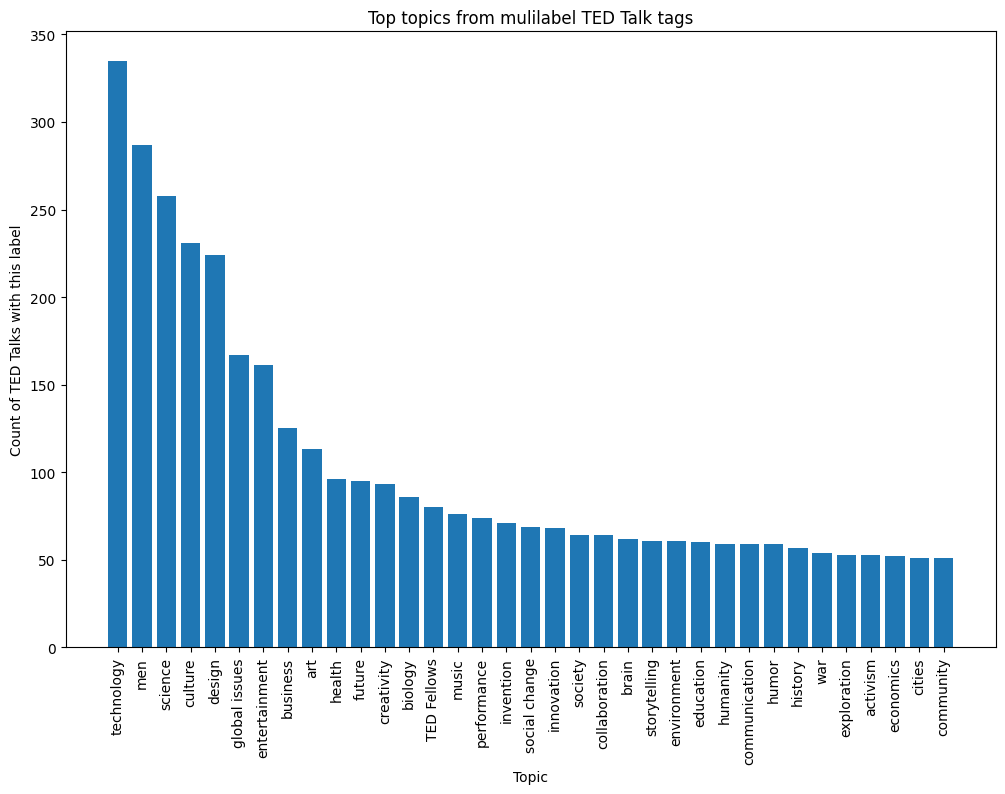

In [45]:
top_counts = [i[1] for i in counts if i[1]> 50]
top_topics = [i[0] for i in counts if i[1] > 50]

fig, ax = plt.subplots(figsize=(12,8))
plt.bar(top_topics, top_counts)
plt.xlabel('Topic')
plt.xticks(rotation=90)
plt.ylabel('Count of TED Talks with this label')
plt.title('Top topics from mulilabel TED Talk tags')
plt.show()

How many of the 900+ TED Talks fall into one of these categories?

In [46]:
count = 0
for idx, row in df.iterrows():
    for col in top_topics:
        if row[col] == 1:
            count +=1
            break

print(count, 'TED talks are labeled as one of the top topic tags')
print('There are {} total topic labels'.format(len(unique_topics)))

974 TED talks are labeled as one of the top topic tags
There are 400 total topic labels


Examining the top assigned labels, the number one topic is "technology," followed by "men," "science," and "culture." Some of these topics are definitely much more percievable than others — how is "culture" or "humanity" defined?

Next, I use the LDA visualization to visualize the 20 topics I used for my earlier model.

In [47]:
pyLDAvis.enable_notebook()
#speech lda vectorizer from before
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lda_vis = pyLDAvis.lda_model.prepare(lda, vectorized_transcripts, lda_vectorizer, mds='pcoa', sort_topics=False)
pyLDAvis.display(lda_vis)

![topic5](topic5.png)

![topic13](topic13.png)

![topic 14](topic14.png)

The LDA topic modeling definitely reveals some interesting groupings within the speeches. Some topics are clear: 5 is speeches related to education and children, 13 relates to energy and efficieny, etc. The topic with the highest distribution of speeches, 14, does not have any clear patterns, and their most identifiable words appear pretty random and generic.

### Exploring Speech/Biography Relationships

Manual examination of speech to biography relationships
These are commented out because the outputs are long and I took notes about them elsewhere.

In [48]:
# #sample 10 speech and biographies
# for i in range(10):
#   data = df.sample(n=1).iloc[0]
#   print(textwrap.fill(data['speaker1_profile'], width=80))
#   print('\n')
#   print(textwrap.fill(data['text'], width=80))
#   print('\n\n')


### Exploring Similarity Matchings

Out of all the similarity matching techniques, the TF-IDF method with cosine_similarity performed the best. I will therefore use that method for sampling some speeches and manually examining the top five most similar biographies returned




In [49]:
def get_top_bios(data, similarity_matrix):
    """
    Returns the top 5 most similar biographies given the similarity_matrix and
    the dataset
    """
    top_five_idx = np.argsort(similarity_matrix[0])[::-1][:5] #indices with highest similarities
    top_five_speeches  = data.iloc[top_five_idx, :]
    for i in top_five_speeches['speaker1_profile']:
      print(textwrap.fill(i, width=80))
      print('\n')

In [50]:
# for i in range(10):
#   true_title, true_text, true_bio = get_speeches(df)
#   sim_matrix = calculate_similarity(true_text, df['speaker1_profile'], text_vectorizer)
#   prediction_assessment(df, sim_matrix[0], true_title)
#   print('\n')
#   print(textwrap.fill(true_bio, 80))
#   print(textwrap.fill(true_text, 80))
#   print('\n')
#   get_top_bios(df, sim_matrix)
#   print('\n')

### Examining Speech Similarities

After analyzing speech-to-biography similarity matching, I want to see how transcripts relate to each other, and if their corresponding biographies seem related or consistent.

In [51]:
def get_most_similar(data, similarity_matrix):
  """
  Given a dataframe and a similarity matrix, return the speaker biography of the
  most similar speech
  """
  #top matching transcript will have a similarity=1, get the second
  top_idx = np.argsort(similarity_matrix[0])[::-1][1]
  top_speaker  = data.iloc[top_idx, :]
  print(textwrap.fill(top_speaker['speaker1_profile'], 80))

In [52]:
# for i in range(10):
#   true_title, true_text, true_bio = get_speeches(df)
#   sim_matrix = calculate_similarity(true_text, df['text'], text_vectorizer)
#   print(true_title+'\n')
#   print(textwrap.fill(true_text, 80))
#   print('\nTrue Biography')
#   print(textwrap.fill(true_bio, 80))
#   print('\nMost Similar Biography')
#   get_most_similar(df, sim_matrix)
#   print('\n')

# 3. Results



Results are both quantitative and qualitative.

1. Review the accuracy results of the similarity models.

2. Examine how the models performed in relation to eachother i.e. if some speeches were more difficult to match across the board.

3. Describe my qualitative findings from manual examiniation of the speech transcripts and speaker biographies.



### Accuracy Results

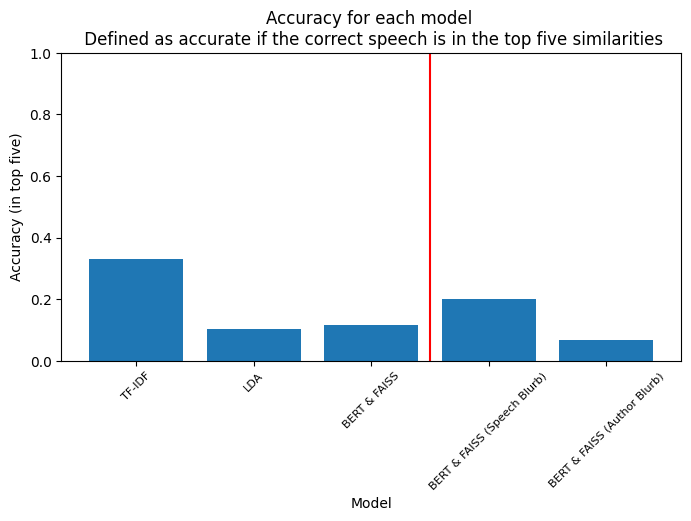

In [53]:
fig, ax = plt.subplots(figsize=(8,4))
plt.bar(results_dict.keys(), results_dict.values())
plt.xlabel('Model')
plt.xticks(fontsize=8, rotation=45)
plt.axvline(x=2.5, color='red')
plt.ylim(0,1)
plt.ylabel('Accuracy (in top five)')
plt.title('Accuracy for each model \n Defined as accurate if the correct speech is in the top five similarities')
plt.show()

In [54]:
results_dict

{'TF-IDF': 0.3316532258064516,
 'LDA': 0.10383064516129033,
 'BERT & FAISS': 0.11491935483870967,
 'BERT & FAISS (Speech Blurb)': 0.20161290322580644,
 'BERT & FAISS (Author Blurb)': 0.06854838709677419}

The first three accuracies are the main models assessed for similarity: both TF-IDF and LDA vectorizers were used alongside similarity, and a BERT tokenizer with FAISS similarity match was used for the third. We see that the TF-IDF vectorizer performed the best, though accuracy was still very low, around 33%. There was built in leniency in this accuracy metric, as a match was considered accurate if it appeared in the top five most similar biographies, it did not have to be the most similar.

I also ran the BERT+FAISS model on similarities between the speech transcript and the speech description, and author blurb. Surprisingly, the similarity between the speech and the description of the speech was low, at about 20%. The similarity between the speech and the author blurb was intuitively lower than all other accuracy scores, as this blurb was even shorter than the author biography.

### Comparing Model Output

When running the three models, I saved the correctly classified speech titles. Here, I examine if there is overlap between what the models got right.





In [55]:
#tfidf_correct, lda_correct, faiss_correct
print('Titles predicted correctly across all thre models \n')
overlap = list(set(tfidf_correct) & set(lda_correct) & set(faiss_correct))
print('Number of overlapped titles across all three models:', len(overlap), '\n')
for item in overlap:
  print(item)

Titles predicted correctly across all thre models 

Number of overlapped titles across all three models: 13 

Sculptures that'd be at home in the deep sea
I leapt from the stratosphere. Here's how I did it
How to restore a rainforest
My escape from North Korea
Greening the ghetto
For more tolerance, we need more ... tourism?
Bluegrass virtuosity from ... New Jersey?
How I brought a river, and my city, back to life
The idea behind Zipcar (and what comes next)
Don't fear intelligent machines. Work with them
There's more to life than being happy
The flower-shaped starshade that might help us detect Earth-like planets
This is Saturn


In [56]:
print('Titles predicted correctly across TF-IDF and LDA')
overlap = list(set(tfidf_correct) & set(lda_correct))
print('Number of overlapped titles across models:', len(overlap), '\n')
for item in overlap:
  print(item)

Titles predicted correctly across TF-IDF and LDA
Number of overlapped titles across models: 60 

Sculptures that'd be at home in the deep sea
New video technology that reveals an object's hidden properties
Can we stop climate change by removing CO2 from the air?
Unseen footage, untamed nature
What happens in your brain when you pay attention?
How behavioral science can lower your energy bill
A promising test for pancreatic cancer ... from a teenager
What does it mean to be a citizen of the world?
My wish: Find the next Einstein in Africa
How (and why) Russia hacked the US election
My stroke of insight
Let's teach religion -- all religion -- in schools
The good news on poverty (Yes, there's good news)
How public spaces make cities work
A look inside the brain in real time
How computers learn to recognize objects instantly
This is Saturn
Can we eat to starve cancer?
3 clues to understanding your brain
I leapt from the stratosphere. Here's how I did it
How to restore a rainforest
My escap

In [57]:
print('Titles predicted correctly across TF-IDF and BERT/FAISS')
overlap = list(set(tfidf_correct) & set(faiss_correct))
print('Number of overlapped titles across models:', len(overlap), '\n')
for item in overlap:
  print(item)

Titles predicted correctly across TF-IDF and BERT/FAISS
Number of overlapped titles across models: 65 

Augmented-reality maps
Sculptures that'd be at home in the deep sea
Unleash your creativity in a Fab Lab
The business logic of sustainability
A guerilla gardener in South Central LA
My journey to yo-yo mastery
Conserving the canopy
The best stats you've ever seen
Why did I ski to the North Pole?
What ants teach us about the brain, cancer and the Internet
10 top time-saving tech tips
An escape from poverty
A new museum wing ... in a giant bubble
I am the son of a terrorist. Here's how I chose peace.
This is Saturn
The NSA responds to Edward Snowden's TED Talk
Magical houses, made of bamboo
The beautiful math of coral
How I made an impossible film
I leapt from the stratosphere. Here's how I did it
How to restore a rainforest
My escape from North Korea
What's hidden under the Greenland ice sheet?
Greening the ghetto
The birth of a word
Architecture for the people by the people
How art g

In [58]:
print('Titles predicted correctly across LDA and BERT/FAISS')
overlap = list(set(lda_correct) & set(faiss_correct))
print('Number of overlapped titles across models:', len(overlap), '\n')
for item in overlap:
  print(item)

Titles predicted correctly across LDA and BERT/FAISS
Number of overlapped titles across models: 20 

Sculptures that'd be at home in the deep sea
This is Saturn
Building the Seed Cathedral
I leapt from the stratosphere. Here's how I did it
How to restore a rainforest
My escape from North Korea
Greening the ghetto
The idea behind Zipcar (and what comes next)
The mysterious lives of giant trees
A next-gen cure for killer infections
For more tolerance, we need more ... tourism?
For parents, happiness is a very high bar
Bluegrass virtuosity from ... New Jersey?
Don't fear intelligent machines. Work with them
There's more to life than being happy
The flower-shaped starshade that might help us detect Earth-like planets
The missing link to renewable energy
The bridge between suicide and life
How I brought a river, and my city, back to life
I'm going to the moon. Who's with me?


<ipython-input-59-e71337c827e5>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', 'TF-IDF', '', 'LDA', '', 'FAISS', '']);
<ipython-input-59-e71337c827e5>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['', 'TF-IDF', '', 'LDA', '', 'FAISS', '']);


Text(0.5, 1.0, 'Color Maps')

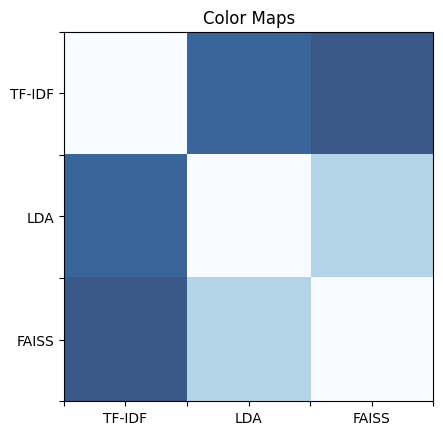

In [59]:
#     tfidf  lda   bert
#tfidf        61    65
#lda    61          24
#bert   65    24
overlaps = [[0, 60, 65], [60, 0, 20], [65, 20, 0]]
fig, ax = plt.subplots()
ax.imshow(overlaps, alpha=0.8, cmap='Blues')
ax.set_xticklabels(['', 'TF-IDF', '', 'LDA', '', 'FAISS', '']);
ax.set_yticklabels(['', 'TF-IDF', '', 'LDA', '', 'FAISS', '']);
ax.set_title('Color Maps')

This color map shows the number of overlapped speeches matched correctly. Of the three models, TF-IDF got 326 "accurate" matches, as I defined accuracy. The darker the square, the more correct matches the models had in common. TF-IDF and FAISS had the most overlap, with 65 of the same speech titles. LDA and FAISS had the least overlap, with 20 of the same speech titles. Overall, there were only 13 speeches classified correctly by all three models. After examination, I have determined that there does not seem to be any relation in topic across these speeches.

### Qualitative Manual Examination of Speech Transcripts and Biographies

I analyzed the TED Talks in three ways:  

1. Relationships between speaker biography and speech
2. Examining the top 5 most similar biographies from the highest performing model
3. Examining the biographies associated with the most similar speech

----

First, I wanted to ascertain if similarities were obvious to me, a human reader, between the transcripts of the speeches and the biographies of their speakers. I randomly sampled and manually examined twenty speech/biography pairs and found some major patterns in how they related to each other:

* **Speeches and their biographies *were* topically related to each other**

One example of this is the speech *My Daughter Malala* by Ziauddin Yousafzai. His speech was about his daugher Malala. The speech and the biography are exactly aligned, as his noteriety is tied to his personal relationship and resulting work.

Another example of this is the speech *Treat design as art* by Paola Antonelli. Her speech is about exhibiting and understanding design and her biography is about her work in museums and whith design. Again — their speech is directly about their lifes work.

* **Speakers had general biographies that didn't provide any context for the speech content**

One example of this is the speech *Should you live for your résumé ... or your eulogy?* by David Brooks. The speech is about legacy and human nature. David Brooks has a long resume: his biography lists being a columnist, commentator, author, professor, studying history, foreign affairs, and editing a book review. The topic of his speech doesn't have a clear tie to any of these things. I would not be able to blindly match biography to speech in this case.

-----

Next, I randomly sampled and examined twenty speeches at random along with the top five most similar biographies. I did this using the TF-IDF vectorizer with cosine similarity model, as that had the highest overall accuracy. Again, I found some broad categories of pattern in how similarities were related.

* **Speeches were found to be most similar as speeches with authors of similar occupations/lines of work**

One example of this is the speech *The mathematics of history* by Jean-Baptiste Michel. Michel's biography outlines a general academic career using data to study human culture and his speech is about the mathematics of historical grammar. Though his biography was not matched in the top five, the other five biographies were all people who worked in history, language, and culture fields, all topically related to the speech.

Another example of this is the speech *A skateboard, with a boost* by Sanjay Dastoor. Dastoor's biography is about his work as an engineer creating an electric longboard and working in robotics and the speech is about the electric skateboard, although *never mentions the word skateboard*. His biography was not matched in the top five, the other five biographies were people who worked in renewable energy research and development.

* **The speech was clearly matched to the correct biography**

One example of the model performing well is the speech *The illusion of consciousness* by Dan Dennett. The themes of human conciousness in this speech were also clearly outlined in his biography.

Another example of this is the speech *Wy wish: Help me stop pandemics* by Larry Brilliant outlining a need for pandemic preparedness. Brilliant's biography about his experience working as a doctor during health epidemics was the top result in the similarity model.
* **The model is picking up on a similar, false positive theme**

An example of this is the speech *Try something new for 30 days* by Matt Cutts about setting new goals. He repeatedly (and understandably) uses the phrase '30 days' in his speech. This concept is not related to his biography about his work as a search optimizer at Google. The biography that was found to be the most similar to his speech was that of Morgan Spurlock whose biography speaks extensively about his TV show '30 days'. The similarity between the transcript and biography, although not a match, are clear, and I feel I would probably tie them together if labeling them manually.

* **The matches between speech and biographies seemed completely unrelated**

An example of this total mismatch is the speech *17 words of architectural inspiration* by Daniel Libeskind, which is about emotional responses to architecture. The top four most similar speeches were people in the space exploration industry. Something about the transcript found false similarities in another topic genre, likely just the frequent use of the word 'space' which Libeskind used in his speech.

-----



Finally, I took a reverse approach to the task: I found the most similar transcript and examined the biography of that transcript. Basically, this allowed me to see if speech similarity corresponded to biography similarity. I didn't find many broad patterns here, mostly a mix between intutitive, positive relationships and ones that seemed fairly broad or random, such as studies of history or technology which tied speeches together.



# Discussion and Conclusion

My first hypothesis posited that models would not be successful at matching speaker biography to their speech, and that hypothesis was validated. Out of the TF-IDF/cosine similarity model, the LDA/cosine similarity model, and the BERT/FAISS model, the best one was the TF-IDf/cosine similarity, and the correct biography match only appeared in the top five most similar matches a third of the time.

There are a few reasons why I think these models did not perform well
1. The basis of the vectorizers for TF-IDF and LDA was the transcript data, and the biographies were vectorized off of those. I did this because the corpus for transcripts was much longer and varied, and because I wanted the topics outlined in the speech to be what connected it to the biography rather than biography specific information such as educational background and place of employment.

2. From manual examiniation, there often was not a clear topical or even semantic relationship between a speech and its speaker's biography. A human performing this task likely would have performed mediocrely.

My second hypothesis was analyzed in a qualitative manner, and this is where the takeaways are most interesting.

1. Biographies are inconsistent with each other. I am not sure if speaker biographies are created by the speaker or by the TED organization, but they differ greatly in their form, length, and level of detail. Some biographies are very traditional outlines of a person's educational background, and a list of all their achievements, publications, etc. Others are short, quippy, and humorous. These distinctions make it difficult to even analyze a person through their biography.

2. The backgrounds and works of speakers were not clearly related to their speech. Speakers who are household names, celebrities, or academic celebrities often gave speeches about topics unrelated to why they were well known, or only tangentally related to their field of expertise. Some people (ahem, Bill Gates), are so universally known and respected that they seem to be given leeway to speak on a range of topics.

3. The topics defined by TED itself are broad and intangible, which translates into the content of the speeches. Having read more TED Talks than I was ever expecting to, I found myself repeatedly asking what the point was of many of these speeches, or who their audience was. Though some were important calls to action on climate change and political advocacy, others were more thought experiments and personal anecdotes.

Overall, the results of this project imply that it is difficult to compare what somebody talks about and how they talk about it to their biography. In examining many TED Talks, I found that their focuses were often very broad — the climate change crisis, refugee crises, public health management, space exploration — or very narrow — their experience in a cult or the engineering feat of a camel. TED Talks are rightfully criticized for their oversimplification, and the effects that has on our ability to learn and think critically. As Frank Romanelli writes in ['Should TED Talks Be Teaching Us Something?](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4140479/), "TED gives learners a false sense of simplicity of the real world and reinforces a convenient approach to learning that one rarely encounters in everyday life." The fact that speakers are difficult to match between speech and biography may not be a facet of their personality or expertise, but rather the way they must fit into the TED Talk mold with its prescribed timing and neat takeaways. TED Talks also platform certain voices over others, and this affects who is given leeway to speak about what. These speeches certainly have positives and negatives in terms of education, outreach, impact, and represntation. At the end of the day, the big topics of culture, policy, war, and technology that are so often discussed in TED Talks (and can't forget about that 'men' category!), are not understood or solved through an 18-minute talk. A person's life cannot be summed up in their biography, nor can their interests and work be summed up in a speech. The results of this project demonstrate the intricacies of self-identification and expertise when trying to move or influence an audience and the constraints set by an organization which obstensibly must limit nuance in order to inform at all. 